### Development Method

1. get public transport location data - NAPTAN a) Clean it if necessary
2. get population location data -  LSOA from ONS
3. use Fiona to read location data
4. limit to one or two locations, e.g. London and a more rural area
5. draw Euclidean Buffers around LSOA polygon centre points
6. find number of public transport stops in the polygon with “points in polygons” approach

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [3]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import requests
import json
import pyproj
from math import cos
from modules import geo_df_from_csv, geo_df_from_geospatialfile, find_points_in_poly, draw_5km_buffer

10:80: E501 line too long (101 > 79 characters)


In [4]:
stops_path = (os.path.join
              (os.getcwd(),
               'data',
               'Stops.txt'))

stops_geo_df = (geo_df_from_csv(path_to_csv=stops_path,
                            delim='\t',
                            geom_x='stop_lon',
                            geom_y='stop_lat'))
stops_geo_df.sample(15)

AttributeError: 'DataFrame' object has no attribute 'crs'

7:29: E128 continuation line under-indented for visual indent
8:29: E128 continuation line under-indented for visual indent
9:29: E128 continuation line under-indented for visual indent


In [160]:
greater_london_path = ((os.path.join
                                (os.getcwd(),
                                 'data',
                                 'greater_london.geojson')))

greater_london_geo_df = geo_df_from_geospatialfile(greater_london_path)

greater_london_geo_df.head()

# Creating a Geo Dataframe of only stops in London
london_stops_geo_df = (find_points_in_poly
                       (geo_df=stops_geo_df,
                        polygon_obj=greater_london_geo_df))

london_stops_geo_df.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
76301,150012891S,esxjdtjp,"Grange Hill, Stradbroke Park (adj)",51.60482,0.07290,NaN,3.0,POINT (0.07290 51.60482)
79876,150042023001,esxatmga,"Grange Hill, Tudor Crescent (adj)",51.60665,0.08303,NaN,3.0,POINT (0.08303 51.60665)
122161,210021803340,hrtajatj,"Batchworth Heath, Mount Vernon Hospital (nr)",51.61460,-0.45066,NaN,3.0,POINT (-0.45066 51.61460)
123431,210021001322,hrtgtdad,"Dancers Hill, The Shires (nr)",51.66453,-0.20933,NaN,3.0,POINT (-0.20933 51.66453)
134927,2400107805,kntjwmdj,"Knockholt, Scotts Lodge (opp)",51.30058,0.08625,NaN,3.0,POINT (0.08625 51.30058)


2:33: E127 continuation line over-indented for visual indent


In [161]:
# Birmingham Census Data
birmingham_map_path = (os.path.join
                   (os.getcwd(),
                    'data',
                    'Birmingham_merged_census_BoundaryData',
                    'england_oac_2011.shp'))

birmingham_census_geo_df = geo_df_from_geospatialfile(birmingham_map_path)

4:20: E128 continuation line under-indented for visual indent
10:1: W391 blank line at end of file


In [162]:
# There is a problem with the "label" column as it contains multiple ONS GSS codes for each observation
def insert_space_middle(str): # Only used for fixing the Birmingham data. Probably a bad import. #HELP
    "A function to insert a space into a string after every 9th digit"
    return " ".join([s[i*9:i*9+9] for i in range(len(s)//9)])

birmingham_census_geo_df.label = birmingham_census_geo_df.label.apply(insert_space_middle)

# birmingham_census_geo_df.label.str.split(expand=True)
birmingham_census_geo_df.label.explode()

0       E08000025 E02001922 E01009286 E00047060
1       E08000025 E02001922 E01009286 E00047060
2       E08000025 E02001922 E01009286 E00047060
3       E08000025 E02001922 E01009286 E00047060
4       E08000025 E02001922 E01009286 E00047060
                         ...                   
3218    E08000025 E02001922 E01009286 E00047060
3219    E08000025 E02001922 E01009286 E00047060
3220    E08000025 E02001922 E01009286 E00047060
3221    E08000025 E02001922 E01009286 E00047060
3222    E08000025 E02001922 E01009286 E00047060
Name: label, Length: 3223, dtype: object

1:80: E501 line too long (103 > 79 characters)
8:1: E305 expected 2 blank lines after class or function definition, found 1
8:80: E501 line too long (90 > 79 characters)


In [163]:
birmingham_json_url = 'https://mapit.mysociety.org/area/2514/children' 

birmingahm_gsscode_dataset = get_and_save_geo_dataset(birmingham_json_url,
                                                  './data/',
                                                  "birmingahm_gsscode_dataset.json")

2:67: W291 trailing whitespace
3:67: W291 trailing whitespace
5:1: W293 blank line contains whitespace
19:71: W291 trailing whitespace
22:51: E128 continuation line under-indented for visual indent
23:51: E128 continuation line under-indented for visual indent
23:80: E501 line too long (84 > 79 characters)
24:1: W391 blank line at end of file


In [164]:
# Trying to read the LSOA for UK via a json but failing
LSOA_url = "https://raw.githubusercontent.com/ONSvisual/topojson_boundaries/master/LSOA.json"
LSOA_data = get_and_save_geo_dataset(url=LSOA_url, 
                         localpath='./data/',
                         filename='LSOA_data.json')                                             

2:80: E501 line too long (93 > 79 characters)
3:51: W291 trailing whitespace
4:26: E128 continuation line under-indented for visual indent
5:26: E128 continuation line under-indented for visual indent
5:52: W291 trailing whitespace


In [165]:
# Getting the Lower Super Output Area for the UK into a dataframe
uk_LSOA_shp_file = "Lower_Layer_Super_Output_Areas__December_2011__Boundaries_EW_BGC.shp"
full_path = os.path.join(os.getcwd(), "data", "LSOA_shp", uk_LSOA_shp_file)
uk_LSOA_df = geo_df_from_geospatialfile(path_to_file=full_path)

2:80: E501 line too long (89 > 79 characters)


In [166]:
# geo_df_from_geospatialfile(os.path.join
#                            (os.getcwd(),
#                             'data',
#                             'birmingham_geo_dataset.json'))


# Manipulating the Birmingham df
# splitting the "codes" column into "gss" and "unit_id"
# setting "id" as the index
    
birmingham_df = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T
gss_code_cols = pd.DataFrame.from_dict(birmingahm_gsscode_dataset).T.codes.apply(pd.Series).drop("ons", axis=1) 
birmingham_df = birmingham_df.join(gss_code_cols).drop(["codes", "all_names"], axis=1) 
birmingham_df.set_index('id', inplace=True)

11:1: W293 blank line contains whitespace
13:80: E501 line too long (111 > 79 characters)
13:112: W291 trailing whitespace
14:80: E501 line too long (86 > 79 characters)
14:87: W291 trailing whitespace


In [167]:
birmingham_df.head()

,parent_area,generation_high,name,country,type_name,generation_low,country_name,type,gss,unit_id
id,,,,,,,,,,
151905,2514,40,Acocks Green,E,Metropolitan district ward,33,England,MTW,E05011118,185
151888,2514,40,Allens Cross,E,Metropolitan district ward,33,England,MTW,E05011119,44822
151917,2514,40,Alum Rock,E,Metropolitan district ward,33,England,MTW,E05011120,63
151943,2514,40,Aston,E,Metropolitan district ward,33,England,MTW,E05011121,22
151933,2514,40,Balsall Heath West,E,Metropolitan district ward,33,England,MTW,E05011122,21


In [168]:
uk_LSOA_df.head()

,FID,LSOA11CD,LSOA11NM,LSOA11NMW,Age_Indica,Shape__Are,Shape__Len,geometry
0,1,E01001019,Croydon 044B,Croydon 044B,0,1.515854e+06,8362.659636,"POLYGON ((-0.12763 51.31428, -0.12746 51.31367..."
1,2,E01000001,City of London 001A,City of London 001A,0,3.439074e+05,3682.439418,"POLYGON ((-0.09726 51.52158, -0.09649 51.52028..."
2,3,E01001020,Croydon 044C,Croydon 044C,0,9.354317e+05,7236.272525,"POLYGON ((-0.12254 51.30867, -0.12172 51.30775..."
3,4,E01001021,Croydon 044D,Croydon 044D,0,5.237812e+06,12160.534720,"POLYGON ((-0.12799 51.30705, -0.12513 51.30561..."
4,5,E01000002,City of London 001B,City of London 001B,0,5.834740e+05,3910.387238,"POLYGON ((-0.08810 51.51941, -0.08927 51.51752..."


In [175]:
#Getting just the Birmingham LSOA
just_birmingham_LSOA = uk_LSOA_df[uk_LSOA_df.LSOA11NM.str.contains("Birmingham")]

#Trying to create a birmingham polygon
just_birmingham_geom = just_birmingham_LSOA.drop(["FID","LSOA11CD","LSOA11NMW","Age_Indica", "Shape__Are","Shape__Len","LSOA11NM"], axis=1)
just_birmingham_geom.city = "birmingham"
just_birmingham_geom['new_column'] = 0
just_birmingham_geom = just_birmingham_geom.dissolve(by='new_column')

,geometry
new_column,
0,"POLYGON ((-1.91409 52.40759, -1.91368 52.40746..."


1:1: E265 block comment should start with '# '
2:80: E501 line too long (81 > 79 characters)
4:1: E265 block comment should start with '# '
5:56: E231 missing whitespace after ','
5:67: E231 missing whitespace after ','
5:79: E231 missing whitespace after ','
5:80: E501 line too long (139 > 79 characters)
5:106: E231 missing whitespace after ','
5:119: E231 missing whitespace after ','


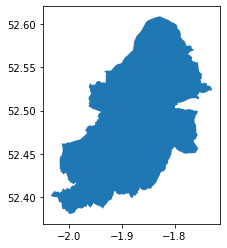

In [177]:
just_birmingham_geom.plot()

<ipython-input-202-33858418173e>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bham_centrepoint = just_birmingham_geom.centroid
<ipython-input-200-df91a870538d>:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return centroid.buffer(distance=degrees)


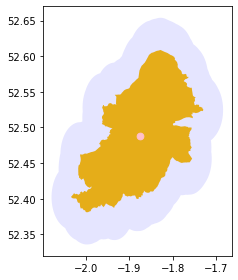

1:1: E266 too many leading '#' for block comment
1:21: W291 trailing whitespace
4:1: E265 block comment should start with '# '
4:8: W291 trailing whitespace
12:62: E261 at least two spaces before inline comment
12:63: E262 inline comment should start with '# '
12:80: E501 line too long (97 > 79 characters)
14:1: W391 blank line at end of file


In [180]:
# Creating a Geo Dataframe of only stops in Birmingham
birmingham_stops_geo_df = (find_points_in_poly
                       (geo_df=stops_geo_df,
                        polygon_obj=just_birmingham_geom))

3:24: E128 continuation line under-indented for visual indent


In [181]:
birmingham_stops_geo_df

,stop_id,stop_code,stop_name,stop_lat,stop_lon,stop_url,vehicle_type,geometry
220835,3800C424102,stadpgaw,"Little Aston, Burnett Road (Opp)",52.58518,-1.87227,NaN,3.0,POINT (-1.87227 52.58518)
248071,4200F080000,waradtdw,"Wishaw, Cock (Adj)",52.54599,-1.75364,NaN,3.0,POINT (-1.75364 52.54599)
249509,43000105102,nwmadjda,"Elmdon, Goodway Rd (opp)",52.45160,-1.76295,NaN,3.0,POINT (-1.76295 52.45160)
249709,43000141708,nwmadmpw,"Five Ways, Morrisons (Stop FT)",52.47188,-1.91956,NaN,3.0,POINT (-1.91956 52.47188)
249723,43000147901,nwmgdgwp,"Yardley Wood, Highfield Rd Island (after)",52.42436,-1.84793,NaN,3.0,POINT (-1.84793 52.42436)
...,...,...,...,...,...,...,...,...
383284,9400ZZWMSH,NaN,"Winson Green, Soho Benson Road (Midland Metro ...",52.49689,-1.93115,NaN,1.0,POINT (-1.93115 52.49689)
383285,9400ZZWMST,NaN,"Jewellery Quarter, St Paul's (Midland Metro Stop)",52.48666,-1.90393,NaN,1.0,POINT (-1.90393 52.48666)
383480,9400ZZWMCOR,NaN,"Birmingham, Corporation Street (Midland Metro ...",52.47985,-1.89718,NaN,1.0,POINT (-1.89718 52.47985)
383692,9400ZZWMBO,NaN,"Handsworth, Handsworth Booth Street (Midland M...",52.50196,-1.95218,NaN,1.0,POINT (-1.95218 52.50196)


<ipython-input-193-4cc6cb95dca3>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bham_centrepoint.buffer(distance=5)


new_column
0    POLYGON ((3.12530 52.48863, 3.10123 51.99855, ...
dtype: geometry

<ipython-input-204-5b6bd8d64eb4>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  bham_centrepoint = just_birmingham_geom.centroid
<ipython-input-200-df91a870538d>:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return centroid.buffer(distance=degrees)


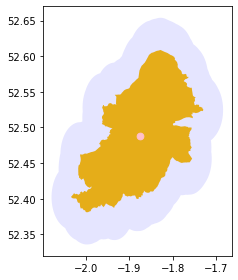

1:1: E266 too many leading '#' for block comment
1:21: W291 trailing whitespace
5:1: E265 block comment should start with '# '
5:8: W291 trailing whitespace
14:62: E261 at least two spaces before inline comment
14:63: E262 inline comment should start with '# '
14:80: E501 line too long (97 > 79 characters)


In [204]:
## Making a centroid 
bham_centrepoint = just_birmingham_geom.centroid
# need to create centroids for the LSOA polygons

#buffer 
buff = draw_5km_buffer(just_birmingham_geom)
# need to create buffers for the LSOA polygons


fig, ax = plt.subplots()
_ = just_birmingham_geom.plot(ax=ax, facecolor='gold')
_ = just_birmingham_geom.plot(ax=ax, color='red', markersize=2, alpha=0.1)
_ = buff.plot(ax=ax, color='blue', markersize=2, alpha=0.1)
_ = bham_centrepoint.plot(ax=ax, color='pink', markersize=45) ## added the centroid into the plot
plt.tight_layout()